In [1]:
import sys
gpuocean_path = [p[:-4] for p in sys.path if (p.endswith("gpuocean/src") or p.endswith("gpuocean\\src"))][0]
import git
repo = git.Repo(gpuocean_path)
print("GPUOcean code from:", repo.head.object.hexsha, "on branch", repo.active_branch.name)

GPUOcean code from: 0a8437ad0fe2fedd63f15b97475eca9468452872 on branch mlda


In [2]:
#Lets have matplotlib "inline"
%matplotlib inline

import os
import sys

#Import packages we need
import numpy as np
from netCDF4 import Dataset
import datetime, copy
from IPython.display import display

#For plotting
import matplotlib
from matplotlib import pyplot as plt

In [3]:
from gpuocean.utils import IPythonMagic, NetCDFInitialization

In [4]:
source_url = "..\\..\\..\\..\\havvarsel-data\\test_polstere.nc"
# source_url = "/sintef/data/OsloFjord/test_polstere_1h_0007.nc"

In [5]:
import xarray as xr
ds = xr.open_dataset(source_url)
ds

<xarray.Dataset>
Dimensions:     (ocean_time: 67, s_rho: 42, s_w: 43, eta_rho: 741, xi_rho: 397, xi_u: 396, eta_v: 740)
Coordinates:
  * ocean_time  (ocean_time) datetime64[ns] 2022-11-16 ... 2022-11-18T18:00:00
  * s_rho       (s_rho) float64 -0.9881 -0.9643 -0.9405 ... -0.03571 -0.0119
  * s_w         (s_w) float64 -1.0 -0.9762 -0.9524 ... -0.04762 -0.02381 0.0
Dimensions without coordinates: eta_rho, xi_rho, xi_u, eta_v
Data variables: (12/15)
    projection  int32 ...
    Cs_r        (s_rho) float64 ...
    Cs_w        (s_w) float64 ...
    h           (eta_rho, xi_rho) float32 ...
    mask_rho    (eta_rho, xi_rho) float32 ...
    angle       (eta_rho, xi_rho) float32 ...
    ...          ...
    salt        (ocean_time, s_rho, eta_rho, xi_rho) float32 ...
    temp        (ocean_time, s_rho, eta_rho, xi_rho) float32 ...
    u           (ocean_time, s_rho, eta_rho, xi_u) float32 ...
    v           (ocean_time, s_rho, eta_v, xi_rho) float32 ...
    lat_rho     (eta_rho, xi_rho) float32 ...
    lon_rho     (eta_rho, xi_rho) float32 ...

In [6]:
dimY, dimX = ds.h.data.shape
x0, x1, y0, y1 = 5, dimX-5, 175, dimY-5

In [7]:
t=50#5*24 + 11 # INPUT

In [8]:
from netCDF4 import Dataset
nc = Dataset(source_url)


In [9]:
import seawater as sw


def potentialDensities(source_url, t=0, x0=0, x1=-1, y0=0, y1=-1):

    s_nc = Dataset(source_url)

    # Collect information about s-levels
    s_lvls = s_nc["Cs_r"][:].data

    # Collect information about domain
    s_hs   = s_nc["h"][y0:y1,x0:x1] + s_nc["zeta"][t,y0:y1,x0:x1]
    s_lats = s_nc["lat_rho"][y0:y1,x0:x1]

    # Fetch temperature and salinity from nc-file 
    s_temps = s_nc["temp"][t,:,y0:y1,x0:x1]
    s_sals  = s_nc["salt"][t,:,y0:y1,x0:x1]

    # Transform depths to pressures 
    s_depths = np.ma.array(np.multiply.outer(s_lvls,s_hs), mask=s_temps.mask.copy())
    s_pressures = sw.eos80.pres(-s_depths,s_lats)

    # Calculate potential densities from salinity, temperature and pressure (depth)
    s_pot_densities = sw.eos80.pden(s_sals,s_temps,s_pressures)

    return s_pot_densities

In [10]:
s_pot_densities = potentialDensities(source_url, t=t, x0=x0, x1=x1, y0=y0, y1=y1)

In [11]:
s_pot_densities.shape

(42, 561, 387)

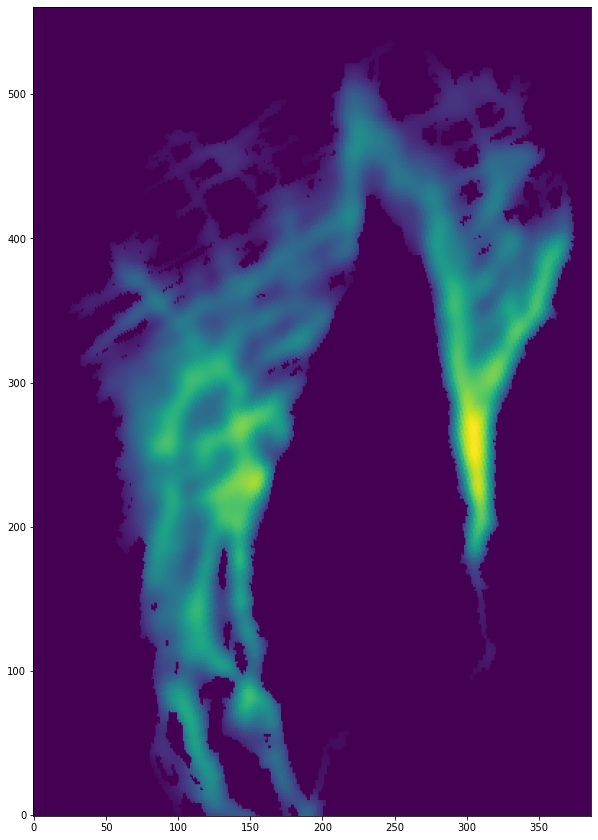

In [12]:
plt.figure(figsize=(10,15))
plt.imshow(nc["h"][y0:y1, x0:x1], origin="lower")

In [13]:
nc["h"][y0:y1, x0:x1][225, 145]

112.77279

In [14]:
s_pot_densities[:,225,145]

masked_array(data=[1027.4112616448508, 1027.4066271369165,
                   1027.397695861607, 1027.3802222782633,
                   1027.3356605879576, 1027.2781386726595,
                   1027.2166676695756, 1027.1437550039827,
                   1027.046437967618, 1026.937210909602,
                   1026.7989788582636, 1026.6681208548173,
                   1026.5182725987065, 1026.3828415147927,
                   1026.2173870604515, 1026.0431168588414,
                   1025.878021790784, 1025.7008972725744,
                   1025.5183087681205, 1025.3473453437068,
                   1025.1700654061679, 1024.9800697759463,
                   1024.750529873379, 1024.5917143723384,
                   1024.177495496863, 1023.8935162409117,
                   1023.6153619579836, 1023.2380398096786,
                   1022.6660922849999, 1022.080254051427,
                   1021.380538993714, 1020.8328493573365,
                   1020.3679875046015, 1020.1517157685715,
     

In [15]:
x_loc = 300 

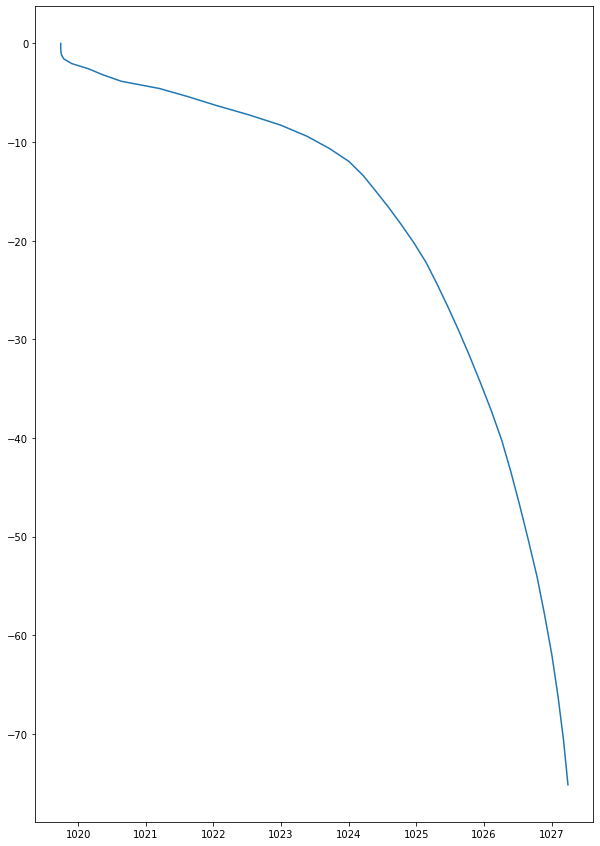

In [16]:
plt.figure(figsize=(10,15))
plt.plot(s_pot_densities[:,x_loc,145], nc["Cs_r"][:].data * nc["h"][y0:y1, x0:x1][x_loc, 145])

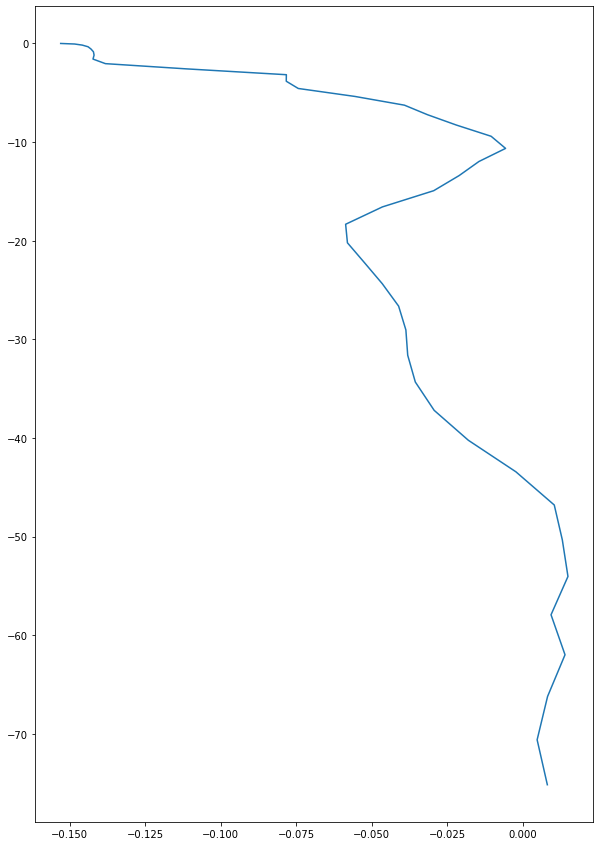

In [17]:
plt.figure(figsize=(10,15))
plt.plot(nc["u"][t,:,y0:y1, x0:x1][:,x_loc,145], nc["Cs_r"][:].data * nc["h"][y0:y1, x0:x1][x_loc, 145])

In [18]:
np.sqrt(nc["ubar"][t,y0:y1, x0:x1][x_loc,145]**2 + nc["vbar"][t,y0:y1, x0:x1][x_loc,145]**2 )

0.028511090606482988

Text(0.5, 0, 'density [kg/m$^3$]')

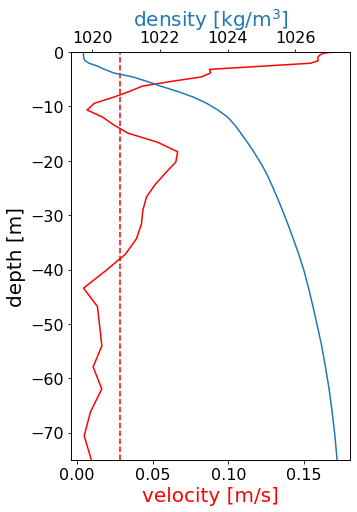

In [28]:
fig, ax1 = plt.subplots(figsize=(5,7.5))

ax1.plot(np.sqrt(nc["u"][t,:,y0:y1, x0:x1][:,x_loc,145]**2 + nc["v"][t,:,y0:y1, x0:x1][:,x_loc,145]**2), nc["Cs_r"][:].data * nc["h"][y0:y1, x0:x1][x_loc, 145], label="velocity [m/s]", c="red")
ax1.tick_params(axis='both', which='major', labelsize=16)
ax1.axvline(np.sqrt(nc["ubar"][t,y0:y1, x0:x1][x_loc,145]**2 + nc["vbar"][t,y0:y1, x0:x1][x_loc,145]**2), ls="--", c="red")
ax1.set_ylim((-75,0))
ax1.set_ylabel("depth [m]", fontsize=20)
ax1.set_xlabel("velocity [m/s]", color="red", fontsize=20)

ax2 = ax1.twiny()
ax2.plot(s_pot_densities[:,x_loc,145], nc["Cs_r"][:].data * nc["h"][y0:y1, x0:x1][x_loc, 145], label =r"density [kg/m$^3$]")
ax2.tick_params(axis='both', which='major', labelsize=16)
ax2.set_xlabel(r"density [kg/m$^3$]", color="C0", fontsize=20)


# lines_1, labels_1 = ax1.get_legend_handles_labels()
# lines_2, labels_2 = ax2.get_legend_handles_labels()
# ax1.legend(lines_2 + lines_1, labels_2 + labels_1, loc=8, fontsize=22)